In [2]:
from google.colab import drive
drive.mount('/content/drive')
%ls
%cd 'drive/MyDrive/Colab Notebooks/DivNet'


Mounted at /content/drive
drive/  sample_data/
/content/drive/MyDrive/Colab Notebooks/DivNet


In [3]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import helperfunc as hf
import torch
import trainers as t
import Networks as n
import pickle
!pip install ipython-autotime
%load_ext autotime

time: 154 µs (started: 2021-03-03 13:36:41 +00:00)


In [4]:
##load data
In = np.load('data/nn_output_10.npy')
out = np.load('data/nn_input_10.npy')
N,Dx = np.shape(In)
N,Dy =np.shape(out)
print('Input shape: ', np.shape(In))
print('Output shape: ',np.shape(out))

## Normalizing
for i in range(Dx):
    if np.min(In[:,i])<-200:
        new_data = (In[:,i]-np.mean(In[:,i]))/(np.std(In[:,i]))
        In[:,i]=new_data
        
from sklearn.model_selection import train_test_split
In, X_test, out, y_test = train_test_split(In, out, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


Input shape:  (1000000, 24)
Output shape:  (1000000, 27)
time: 6.36 s (started: 2021-03-03 13:36:41 +00:00)


In [5]:
config_single ={
         "lr":1e-3,
         "epochs": 100,
         "batch_size": 32,
         "iters": 1000,#int(N/32),
         "input_dim" : Dx,
         "output_dim" : Dy,
         "hidden1" :700,
         "hidden2" :700,
         "display_interval":20,
         "print_it" : True,
         "save":True
    }


time: 3.97 ms (started: 2021-03-03 13:37:00 +00:00)


In [16]:
PATH="single_dict_model.pt"
if config_single["save"]:
  
  NNl, critl,mselosst,train_loss_s,val_loss=t.trainsingle(config_single,In,out,X_val,y_val)
  torch.save(NNl.state_dict(), PATH)
  plot=True
else:
  NNl = n.Large_NN(config_single)
  NNl.load_state_dict(torch.load(PATH))
  NNl.eval()
  mselosst=0.0049
  plot=False

print('Single Network Loss: ',mselosst)

starting training
iter :  0 	 train loss :0.091
iter :  20 	 train loss :0.001
iter :  40 	 train loss :0.000
iter :  60 	 train loss :0.000
iter :  80 	 train loss :0.001
Single Network Loss:  0.07328765094280243
time: 2min 35s (started: 2021-03-02 17:53:01 +00:00)


In [6]:
if plot:
  plt.figure(1,figsize=(10,8))
  plt.plot(np.log10(train_loss),'g-')
  plt.plot(np.log10(val_loss),'r-')
  plt.title("Training and valiation loss")
  plt.xlabel("No. of epochs")
  plt.ylabel("Log10 MSE loss")
  plt.legend(['Training Loss', 'Validation Loss'])

time: 2.44 ms (started: 2021-03-02 16:09:32 +00:00)


In [48]:
#cor = hf.corr(In,out,Dx,Dy)

#print(np.argmin(cor))
config_section ={
        "init_select":4,
        "runs":50,
         "lr":2e-3,
         "epochs": 50,
         "batch_size": 32,
         "iters": 100,#int(N/32),
         "input_dim" : Dx,
         "output_dim" : Dy,
         "hidden1" :80,
         "hidden2" :80,
         "display_interval":30,
         "print_it" : True,
         "c":50,
         "ref_s": 7,#int(np.ceil(Dx/Dy)),
         "ref_v":np.var(In),
         "phi_1":1.0,
         "phi_2":1e-1,
         "phi_3":1e-3,
         "beta":0.1,
         "save":False,
         "dim":6#np.argmin(cor) #fixed value to avaoid calculating correlation every time
    }

time: 101 ms (started: 2021-03-03 14:40:55 +00:00)


In [10]:
SN = config_section["init_select"]
iters = config_section["runs"]
dim = config_section["dim"]

l=np.zeros((iters,4))

sns=np.zeros(iters)
on,bn = hf.init_s(SN,dim,In)
dmse = np.zeros(iters)
ds = np.zeros(iters)
dv = np.zeros(iters)

mse_best=10000
best_config={}

for i in range(iters):
    NN, crit,all_in,all_out,lossind,train_loss,test_loss = t.trainsect(config_section, In, out,SN,on,bn,X_val,y_val)
    if mse_best >=np.mean(lossind):
        mse_best=np.mean(lossind)
        best_config['NN']=NN
        best_config['o']=on
        best_config['b']=bn
        best_config['sn']=SN
        best_config['crit']=crit
        best_config['all_in']=all_in
        best_config['all_out']=all_out
    l[i,:]=hf.loss_1(all_in,all_out,SN,bn,on,config_section,NN,lossind,mselosst)
    
    bold,bnew,dmse[i],dv[i],ds[i] =hf.update_b(In,all_in,all_out,bn,on,SN,NN,config_section,lossind,mselosst,thresh=0.2)
    
    SN,bn,on =hf.gen_s_b_o(bold,bnew,on,config_section,In)

    print('run: ',i,' Sn: ',SN,' bnew: ',bn, 'bold: ',bold, '\n \t LOSS2: ',np.mean(lossind),'\n mse:',l[i,1],'varloss:',l[i,2],'sloss:',l[i,3])
    sns[i]=SN
    

sorting data for section:  0
starting training for section:  0


/content/drive/MyDrive/Colab Notebooks/DivNet/helperfunc.py:6: RuntimeWarning: overflow encountered in exp
  return np.nan_to_num(1/(1+ np.exp(slope*(data-(offset+band)))), copy=True, nan=0.0, posinf=500, neginf=-500)


iter :  0 	 train loss :7.545
iter :  30 	 train loss :0.009
data points for section:0 are:  1542
sorting data for section:  1
starting training for section:  1
iter :  0 	 train loss :0.381
iter :  30 	 train loss :0.010
data points for section:1 are:  528995
sorting data for section:  2
starting training for section:  2
iter :  0 	 train loss :1.065
iter :  30 	 train loss :0.006
data points for section:2 are:  166021
sorting data for section:  3
starting training for section:  3


/content/drive/MyDrive/Colab Notebooks/DivNet/helperfunc.py:9: RuntimeWarning: overflow encountered in exp
  return np.nan_to_num(1/(1+ np.exp(slope*(-data+offset))), copy=True, nan=0.0, posinf=500, neginf=-500)


iter :  0 	 train loss :3.154
iter :  30 	 train loss :0.009
data points for section:3 are:  3442
run:  0  Sn:  6  bnew:  [5.31564442 0.2        5.28742807 5.40231755 4.05134751 1.38062177] bold:  [5.40933983 5.40933983 5.40933983 5.40933983] 
 	 LOSS2:  0.01867969217710197 
 mse: 0.01745469217710197 varloss: 620.0098985260356 sloss: 0.5596157879354228
sorting data for section:  0
starting training for section:  0
iter :  0 	 train loss :30.835
iter :  30 	 train loss :0.012
data points for section:0 are:  1467
sorting data for section:  1
starting training for section:  1
iter :  0 	 train loss :7.642
iter :  30 	 train loss :0.007
data points for section:1 are:  165
sorting data for section:  2
starting training for section:  2
iter :  0 	 train loss :1.028
iter :  30 	 train loss :0.007
data points for section:2 are:  148766
sorting data for section:  3
starting training for section:  3
iter :  0 	 train loss :0.532
iter :  30 	 train loss :0.010
data points for section:3 are:  5461

In [ ]:
#### saving best model and plotting progress
"""
plt.plot(l[:,0],'b-x')
plt.plot(l[:,1],'g-x')
plt.plot(l[:,2],'r-x')
plt.plot(l[:,3],'y-x')
plt.legend(['l1', 'mse', 'var_loss','sloss'])
"""

#NN=best_config['NN']
#on=best_config['o']
#bn=best_config['b']
#SN=best_config['sn']
#crit=best_config['crit']
#all_in=best_config['all_in']
#all_out=best_config['all_out']



In [11]:
config_section["iters"] = 1000
config_section["epochs"] = 100

NN, crit,all_in,all_out,lossind,train_loss,test_loss = t.trainsect(config_section, In, out,SN,on,bn,X_val,y_val)

sorting data for section:  0
starting training for section:  0


/content/drive/MyDrive/Colab Notebooks/DivNet/helperfunc.py:6: RuntimeWarning: overflow encountered in exp
  return np.nan_to_num(1/(1+ np.exp(slope*(data-(offset+band)))), copy=True, nan=0.0, posinf=500, neginf=-500)


iter :  0 	 train loss :0.998
iter :  30 	 train loss :0.002
iter :  60 	 train loss :0.002
iter :  90 	 train loss :0.002
data points for section:0 are:  2126
sorting data for section:  1
starting training for section:  1
iter :  0 	 train loss :0.183
iter :  30 	 train loss :0.002
iter :  60 	 train loss :0.002
iter :  90 	 train loss :0.003
data points for section:1 are:  1342
sorting data for section:  2
starting training for section:  2
iter :  0 	 train loss :0.377
iter :  30 	 train loss :0.002
iter :  60 	 train loss :0.002
iter :  90 	 train loss :0.002
data points for section:2 are:  6546
sorting data for section:  3
starting training for section:  3
iter :  0 	 train loss :0.068
iter :  30 	 train loss :0.003
iter :  60 	 train loss :0.006
iter :  90 	 train loss :0.003
data points for section:3 are:  45065
sorting data for section:  4
starting training for section:  4
iter :  0 	 train loss :0.067
iter :  30 	 train loss :0.005
iter :  60 	 train loss :0.003
iter :  90 	 tr

/content/drive/MyDrive/Colab Notebooks/DivNet/helperfunc.py:9: RuntimeWarning: overflow encountered in exp
  return np.nan_to_num(1/(1+ np.exp(slope*(-data+offset))), copy=True, nan=0.0, posinf=500, neginf=-500)


iter :  0 	 train loss :0.249
iter :  30 	 train loss :0.002
iter :  60 	 train loss :0.003
iter :  90 	 train loss :0.003
data points for section:5 are:  5336
sorting data for section:  6
starting training for section:  6
iter :  0 	 train loss :0.830
iter :  30 	 train loss :0.002
iter :  60 	 train loss :0.002
iter :  90 	 train loss :0.002
data points for section:6 are:  1684
sorting data for section:  7
starting training for section:  7
iter :  0 	 train loss :0.894
iter :  30 	 train loss :0.002
iter :  60 	 train loss :0.002
iter :  90 	 train loss :0.001
data points for section:7 are:  280
sorting data for section:  8
starting training for section:  8
iter :  0 	 train loss :1.970
iter :  30 	 train loss :0.002
iter :  60 	 train loss :0.001
iter :  90 	 train loss :0.002
data points for section:8 are:  443
time: 22min 33s (started: 2021-03-02 17:24:26 +00:00)


In [58]:
config_section["save"]=False
# Saving the objects:
if config_section["save"]:
  for i in range(SN):
    PATH="section_dict_model30"+str(i)+".pt"
    torch.save(NN[str(i)].state_dict(), PATH)

  with open('params30.pkl', 'wb') as f:  
    pickle.dump([SN, bn, on], f)
else:
  # Getting back the objects:
  #"""
  with open('params30.pkl','rb') as f:  
    SN, bn, on = pickle.load(f)
  NN={}
  for i in range(SN):
    PATH="section_dict_model30"+str(i)+".pt"
    NN[str(i)]=n.section_NN(config_section)
    NN[str(i)].load_state_dict(torch.load(PATH))
  #"""
  

time: 31.1 ms (started: 2021-03-02 18:11:05 +00:00)


In [ ]:
print(np.max(In[:,6]),np.min(In[:,6]))

NameError: ignored

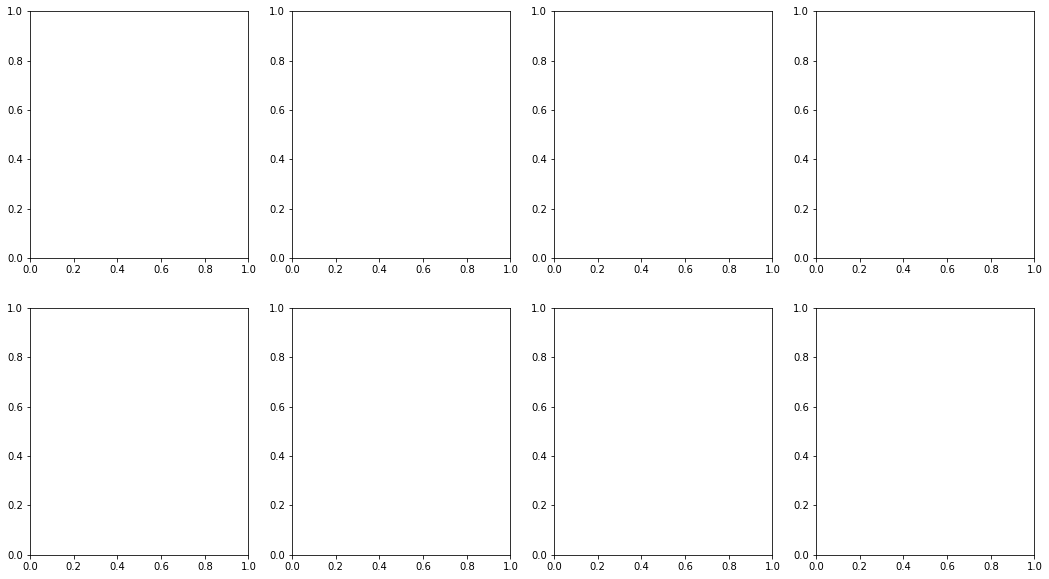

time: 1.33 s (started: 2021-03-03 15:58:26 +00:00)


In [60]:
fig, axs = plt.subplots(2, 4, figsize=(18,10))

for i in range(SN-1):
  if i<4:
    #axs[0,i].plot(train_loss[str(i)][0:300],'r-')
    axs[0,i].plot(np.log10(train_loss[str(i)]),'g-')
    axs[0,i].plot(np.log10(train_loss_s[0:100]),'b-')
    axs[0,i].set_title("TinyNet section "+str(i))
    axs[0,i].set_xlabel("No. of epochs")
    axs[0,i].set_ylabel("Log10 of MSE loss")
    axs[0,i].legend(['Training Loss TinyNets', 'Training Loss SingleNet'])
    
  else:
    #axs[0,i].plot(train_loss[str(i)][0:300],'r-')
    axs[1,i-4].plot(np.log10(train_loss[str(i)]),'g-')
    axs[1,i-4].plot(np.log10(train_loss_s[0:100]),'b-')
    axs[1,i-4].set_title("TinyNet section "+str(i))
    axs[1,i-4].set_xlabel("No. of epochs")
    axs[1,i-4].set_ylabel("Log10 of MSE loss")
    axs[1,i-4].legend(['Training Loss TinyNets', 'Training Loss SingleNet'])
  

Text(0, 0.5, 'log10 of MSE loss')

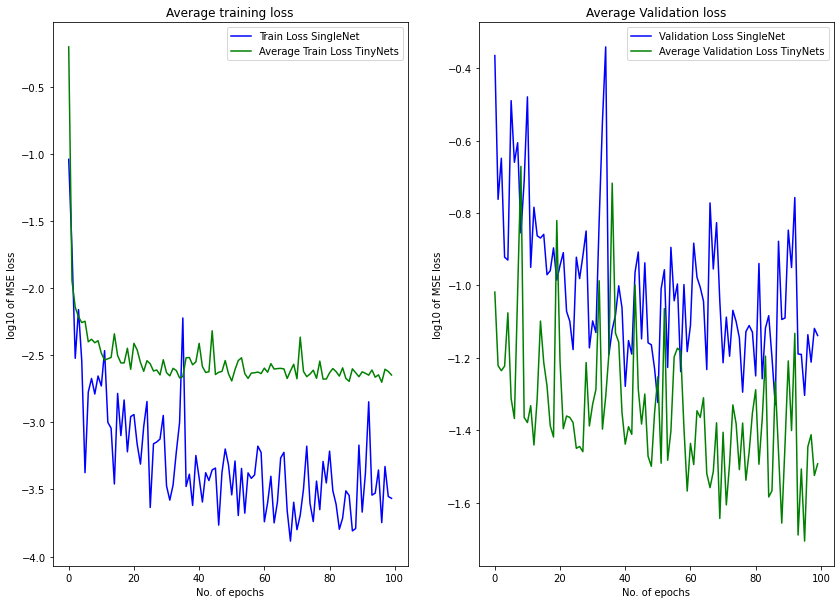

time: 374 ms (started: 2021-03-02 18:03:29 +00:00)


In [26]:
lim=100
tlossav_tiny = np.zeros(100)
vlossav_tiny = np.zeros(100)
for i in range(SN):

    tlossav_tiny += train_loss[str(i)][0:lim]
    vlossav_tiny += test_loss[str(i)][0:lim]

tlossav_tiny /= SN
vlossav_tiny /= SN 
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,10)) 
ax1.plot(np.log10(train_loss_s[0:lim]),'b-')  
ax1.plot(np.log10(tlossav_tiny),'g-')
ax2.plot(np.log10(val_loss[0:lim]),'b-')  
ax2.plot(np.log10(vlossav_tiny),'g-')
ax1.set_title("Average training loss")
ax1.set_xlabel("No. of epochs")
ax1.set_ylabel("log10 of MSE loss")
ax1.legend(['Train Loss SingleNet', 'Average Train Loss TinyNets'])
ax2.legend(['Validation Loss SingleNet','Average Validation Loss TinyNets'])

ax2.set_title("Average Validation loss")
ax2.set_xlabel("No. of epochs")
ax2.set_ylabel("log10 of MSE loss")

In [15]:
config_tiny ={
        "input_dim":1,
        "output_dim":1,
        "hidden1": 3,
        "hidden2":2,
        "lr":2e-3,
        "epochs": 100,
        "batch_size": 400,
        "iters": int(N/400),
        "display_interval":10,
        "print_it":True,
        "dim":config_section["dim"]
}

time: 4.32 ms (started: 2021-03-03 13:47:14 +00:00)


In [59]:
Nt,Dt = np.shape(X_test)
PATH="tiny_dict_model.pt"

NNt = n.tiny_NN(config_tiny)#.to(device)
NNt.load_state_dict(torch.load(PATH))

with open('params30.pkl','rb') as f:  
    SN, bn, on = pickle.load(f)
NN={}
for i in range(SN):
    PATH="section_dict_model30"+str(i)+".pt"
    NN[str(i)]=n.section_NN(config_section)
    NN[str(i)].load_state_dict(torch.load(PATH))

PATH="single_dict_model.pt"

NNl = n.Large_NN(config_single)
NNl.load_state_dict(torch.load(PATH))

RuntimeError: ignored

time: 25.4 ms (started: 2021-03-03 15:55:48 +00:00)


In [50]:

dim = config_tiny["dim"]
data,labels= hf.generate_rdata(SN,on,bn,In,dim)
val_data,val_labels =hf.generate_rdata(SN,on,bn,X_val,dim)
test_data,test_labels =hf.generate_rdata(SN,on,bn,X_test,dim)

NNt, criteriont,train_lossl,val_lossl=t.traintiny(config_tiny, data,labels,val_data,val_labels)


starting training
iter :  0 	 train loss :1.899
iter :  10 	 train loss :0.019
iter :  20 	 train loss :0.010
iter :  30 	 train loss :0.011
iter :  40 	 train loss :0.006
iter :  50 	 train loss :0.013
iter :  60 	 train loss :0.014
iter :  70 	 train loss :0.023
iter :  80 	 train loss :0.003
iter :  90 	 train loss :0.007
time: 10min 43s (started: 2021-03-03 14:41:25 +00:00)


In [55]:
PATH="tiny_dict_model.pt"
torch.save(NNt.state_dict(), PATH)

time: 7.54 ms (started: 2021-03-03 15:51:03 +00:00)


In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#NNt.to(device)
NNt.eval()
test_data = torch.tensor(test_data, dtype=torch.float).to(device) #  tensor
outputs = NNt(test_data)
outs=np.round(outputs.cpu().detach().numpy())
tot=np.abs(outs-test_labels)
tottest= np.sum(tot)
print('Incorrect labels', tottest/np.size(test_labels))

data = torch.tensor(data, dtype=torch.float).to(device) #  tensor
outputs = NNt(data)
outs=np.round(outputs.cpu().detach().numpy())
tot=np.abs(outs-labels)
tottrain= np.sum(tot)

val_data = torch.tensor(val_data, dtype=torch.float).to(device) #  tensor
outputs = NNt(val_data)
outs=np.round(outputs.cpu().detach().numpy())
tot=np.abs(outs-val_labels)
totval= np.sum(tot)

Incorrect labels 0.01882
time: 38.5 ms (started: 2021-03-03 15:50:51 +00:00)


In [53]:
Ntrain = np.size(labels)
Nval = np.size(val_labels)
Ntest = np.size(test_labels)

print('Train Accuracy: ',(Ntrain - tottrain)*100/Ntrain,'%')
print('Validation Accuracy: ',(Nval - totval)*100/Nval,'%')
print('Test Accuracy: ',(Ntest - tottest)*100/Ntest,'%')

Train Accuracy:  98.18157142857143 %
Validation Accuracy:  98.17666666666666 %
Test Accuracy:  98.118 %
time: 4.41 ms (started: 2021-03-03 15:50:54 +00:00)


In [46]:
import torch.nn as nn
def test(NNt,NN,X_test, y_test,SN,dim,on,bn):
    criterion = nn.MSELoss()
    #NNt.eval()
    N,D = np.shape(X_test)
    X_test = torch.tensor(X_test, dtype=torch.float,requires_grad=False)#.to(device)
    y_test = torch.tensor(y_test, dtype=torch.float)#.to(device) #  tensor
    selectors = NNt(torch.reshape(X_test[:,dim],(N,1))).cpu().detach().numpy()
    loss = 0 
    q = [int(np.round(x)) for x in selectors]
    print('calculating loss')

    #for i in range(SN):
    #  NN[str(i)].eval()
    for j in range(N):
        ypred=NN[str(q[j])](X_test[j])
        loss += criterion(ypred, y_test[j]).item()  

    return loss/N

time: 10.6 ms (started: 2021-03-03 14:07:16 +00:00)


In [57]:
dim = config_tiny["dim"]
loss = test(NNt,NN,X_test[0:1000],y_test[0:1000],SN,dim,on,bn)
print('test loss =', loss)

calculating loss
test loss = 306.2832007667897
time: 328 ms (started: 2021-03-03 15:51:18 +00:00)


In [41]:
print('time per data point:',153/Nt)

time per data point: 0.00018571428571428572
time: 988 µs (started: 2021-03-02 18:05:53 +00:00)


In [47]:
#dim = config_tiny["dim"]
loss = test(NNt,NN,In,out,SN,dim,on,bn)
print('train loss =', loss)

calculating loss
train loss = 0.07570796509713755
time: 3min 39s (started: 2021-03-03 14:10:05 +00:00)


In [64]:
Nt,Dt = np.shape(In)

print('time per data point:',669/Nt)

time per data point: 0.0009557142857142858
time: 1.6 ms (started: 2021-03-02 18:12:03 +00:00)


In [48]:
def testl(NNl,X_test, y_test):
    criterion = nn.MSELoss()
    N,D = np.shape(X_test)
    #NNl.to(device)
    X_test = torch.tensor(X_test, dtype=torch.float,requires_grad=False)#.to(device)
    y_test = torch.tensor(y_test, dtype=torch.float)#.to(device) #  tensor
    loss = 0 
    print('calculating loss')
    NNl.eval()
    ypred=NNl(X_test)
    loss += criterion(ypred, y_test).item()

    return loss

time: 5.78 ms (started: 2021-03-02 18:08:28 +00:00)


In [49]:
PATH="single_dict_model.pt"

NNl = n.Large_NN(config_single)
NNl.load_state_dict(torch.load(PATH))
#NNl.eval()
dim = config_tiny["dim"]

time: 13.1 ms (started: 2021-03-02 18:08:38 +00:00)


In [65]:
loss = testl(NNl,X_test,y_test)
print('test loss =', loss)

calculating loss
test loss = 0.07434766739606857
time: 1.18 s (started: 2021-03-02 18:17:38 +00:00)


In [66]:
Nt,Dt = np.shape(X_test)

print('time per data point:',1210/Nt)

time per data point: 0.008066666666666666
time: 1.33 ms (started: 2021-03-02 18:17:40 +00:00)


In [52]:
dim = config_tiny["dim"]
loss = testl(NNl,In,out)
print('train loss =', loss)

calculating loss
train loss = 0.07328765094280243
time: 6.66 s (started: 2021-03-02 18:08:57 +00:00)


In [53]:
Nt,Dt = np.shape(In)

print('time per data point:',6660/Nt)

time per data point: 0.009514285714285715
time: 2.14 ms (started: 2021-03-02 18:09:10 +00:00)
